Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   3.2s
[CV] END .......................C=0.1, gamma=0.

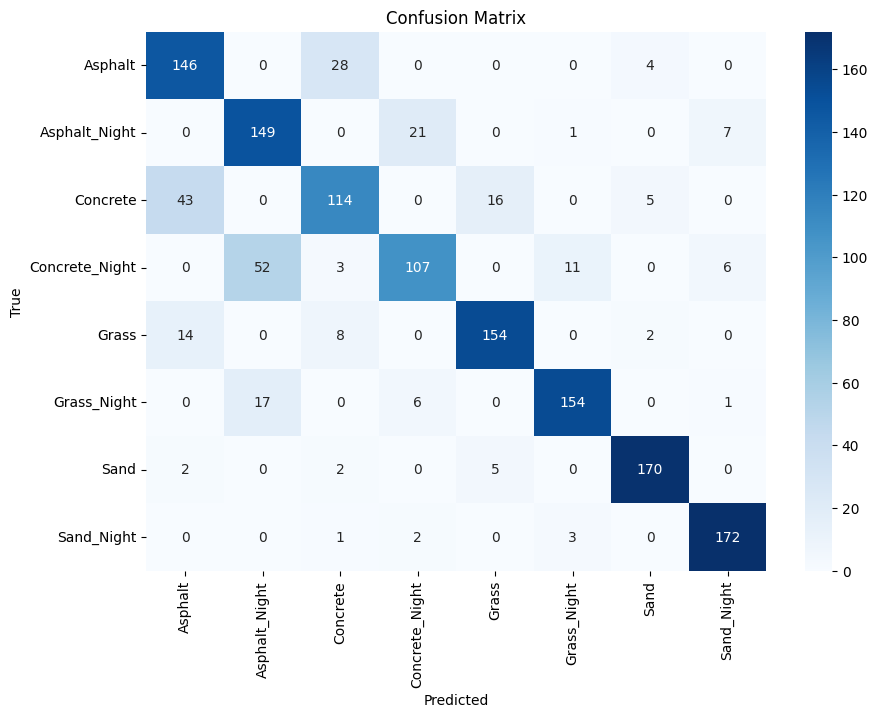

Model saved at E:\Files of UOSJ\Fourth Year\Seventh Semester\Research\RestNet50\svm_classifier_tuned_with_probabilities_night.joblib


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from joblib import dump
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data file
data_path = 'E:\\Files of UOSJ\\Fourth Year\\Seventh Semester\\Research\\RestNet50\\LidarDataset2.csv'
data = pd.read_csv(data_path)

# Determine if a timestamp is during the day or night
def day_or_night(timestamp):
    # Convert to 24-hour time
    time = datetime.strptime(timestamp, '%I:%M:%S %p').time()
    if time >= datetime.strptime('6:00:00 AM', '%I:%M:%S %p').time() and time < datetime.strptime('5:00:00 PM', '%I:%M:%S %p').time():
        return 'day'
    else:
        return 'night'

# Apply the function to create the Day/Night feature
data['Day/Night'] = data['Timestamp'].apply(day_or_night)

# Prepare features and target
X = data[['Moving Average Strength 30', 'WTC Strength at scale 5', 'Distance x ROC Strength', 'Day/Night']]
y = data['Floor Type']

# Convert categorical data to numerical format
X = pd.get_dummies(X) 

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split of the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Initialize and train the SVM Classifier  
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}
grid = GridSearchCV(SVC(probability=True, class_weight=class_weights_dict, random_state=42), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Predict probabilities on the test set
prob_predictions = grid.predict_proba(X_test)
y_pred = grid.predict(X_test)

# Print class probabilities  
class_labels = grid.classes_
for index, probs in enumerate(prob_predictions):
    print(f"Probabilities for test sample {index}:")
    for label, prob in zip(class_labels, probs):
        print(f"  {label}: {prob:.4f}")
    print()  # Just to add a newline for better readability

# Evaluate the model using the final predictions
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
logloss = log_loss(y_test, prob_predictions)

# Output evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("Log Loss:", logloss)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

model_path = 'E:\\Files of UOSJ\\Fourth Year\\Seventh Semester\\Research\\RestNet50\\svm_classifier_tuned_with_probabilities_night.joblib'
dump(grid, model_path)

print(f"Model saved at {model_path}")
